# Inicialização

In [25]:
from datetime import datetime

import gtfs_kit as gk
import pandas as pd
import swifter
import seaborn as sns

In [2]:
from pathlib import Path

path = Path("./gtfs_rio-de-janeiro.zip")

feed = gk.read_feed(path, dist_units='km')

feed.validate()

,type,message,table,rows
3,error,Invalid route_type; maybe has extra space char...,routes,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,Unrecognized column agency_id,fare_rules,[]
2,warning,Unrecognized column feed_contact_email,feed_info,[]
4,warning,Unrecognized column platform_code,stops,[]


# Parâmetros

In [3]:
route = '309'
position_parquet_file = './309_2023.parquet'

# Preparação de dados da rota

In [4]:
route_id = feed.routes[feed.routes['route_short_name'] == route]['route_id'].iloc[0]
route_id

'O0309AAA0A'

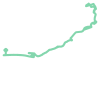

In [5]:
from shapely import LineString, Point

route_geometry: LineString = feed.geometrize_routes([route_id])['geometry'].iloc[0]
route_geometry


In [17]:
stop_ids = feed.get_stops(route_ids=[route_id])['stop_id']
geometrized_stops = feed.geometrize_stops(stop_ids)[['stop_id', 'geometry']]
geometrized_stops['projection'] = geometrized_stops['geometry'].apply(lambda x: route_geometry.project(x))
geometrized_stops.sort_values(by='projection', inplace=True)
geometrized_stops.head()

,stop_id,geometry,projection
6929,wcdt,POINT (-43.36520 -23.00147),0.000000
4091,4128O00209C0,POINT (-43.36633 -23.00904),0.027430
4052,4128O00035C0,POINT (-43.36793 -23.01099),0.035633
4100,4128O00036C0,POINT (-43.36461 -23.01085),0.038958
4046,4128O00037C0,POINT (-43.35939 -23.01065),0.044180


# Preparação de dados de ônibus

In [10]:
bus_positions = pd.read_parquet(position_parquet_file)
bus_positions.timestamp_gps = pd.to_datetime(bus_positions.timestamp_gps)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min
0,2023-03-27 16:13:19,-23.01238,-43.29300,66,37.5
1,2023-03-27 17:04:57,-23.01201,-43.29164,67,18.6
2,2023-03-27 08:30:42,-23.00583,-43.36618,68,13.7
3,2023-03-27 11:08:08,-23.00208,-43.36736,58,40.7
4,2023-02-18 14:05:53,-23.00146,-43.36510,2,15.1
...,...,...,...,...,...
34383788,2023-08-09 17:24:36,-23.00955,-43.28734,56,33.7
34383789,2023-06-20 17:59:11,-22.99779,-43.26467,56,38.3
34383790,2023-10-02 13:23:26,-22.99683,-43.26124,56,38.4
34383791,2023-11-01 15:16:22,-23.01070,-43.33593,56,38.5


# Cálculo de localização

## Localização relativa do ônibus na rota

In [11]:
def project_location(bus_location: tuple[float, float]):
    bus_location_on_route = route_geometry.interpolate(route_geometry.project(Point(bus_location)))
    return route_geometry.project(bus_location_on_route)

In [12]:
bus_positions['relative_distance'] = bus_positions[['latitude', 'longitude']].swifter.apply(lambda x: project_location((x['longitude'], x['latitude'])), axis=1)
bus_positions.sample(10)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

## Parada onde o ônibus está

In [18]:
bus_positions['next_stop_index'] = geometrized_stops['projection'].searchsorted(bus_positions['relative_distance'], side='right')
bus_positions['previous_stop_index'] = bus_positions['next_stop_index'] - 1
bus_positions.sample(10)

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,point,relative_distance,next_stop_index,previous_stop_index
14763146,2023-03-31 14:17:02,-22.96185,-43.21501,35,6.6,0.221639,0.221639,35,34
20496619,2023-01-04 01:52:40,-22.87444,-43.24129,0,0.5,0.340089,0.340089,70,69
10737430,2023-01-08 04:31:51,-22.87510,-43.24179,0,0.0,0.340089,0.340089,70,69
33544743,2023-09-20 00:46:10,-22.87502,-43.24139,0,1.6,0.340089,0.340089,70,69
21294862,2023-08-03 16:17:32,-22.97215,-43.22414,0,3.7,0.468214,0.468214,108,107
13572422,2023-05-08 02:25:11,-22.90467,-43.19261,0,3.5,0.340590,0.340590,70,69
23091653,2023-08-04 11:20:22,-23.00226,-43.36524,31,18.2,0.681294,0.681294,141,140
11485958,2023-01-15 01:38:42,-22.87559,-43.24038,0,0.0,0.340089,0.340089,70,69
6999478,2023-05-25 20:57:28,-23.01181,-43.31042,35,39.4,0.599466,0.599466,127,126
6597679,2023-02-24 06:09:41,-22.97819,-43.22672,20,26.4,0.475200,0.475200,110,109


## Distância do ônibus até a rota

In [22]:
def distance_from_route(bus_location: tuple[float, float]):
    return route_geometry.distance(Point(bus_location))

In [23]:
bus_positions['distance_from_route'] = bus_positions[['latitude', 'longitude']].swifter.apply(lambda x: distance_from_route((x['longitude'], x['latitude'])), axis=1)
bus_positions.sample(10)

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,point,relative_distance,next_stop_index,previous_stop_index,distance_from_route
24877591,2023-06-24 01:47:03,-22.92037,-43.17467,0,22.9,0.381816,0.381816,80,79,0.000057
13273046,2023-05-25 20:00:20,-22.96040,-43.20534,11,0.0,0.231466,0.231466,39,38,0.000039
25970341,2023-09-15 12:03:26,-22.90530,-43.19250,0,15.6,0.339210,0.339210,70,69,0.000213
12804359,2023-05-30 14:57:12,-22.90442,-43.19256,0,0.7,0.340695,0.340695,70,69,0.000222
1793078,2023-05-01 02:14:31,-22.93546,-43.17408,0,14.3,0.283581,0.283581,54,53,0.000004
26322258,2023-06-05 07:20:13,-23.01053,-43.33847,8,21.9,0.065112,0.065112,9,8,0.000025
28084550,2023-06-23 10:08:20,-22.97106,-43.22323,45,15.4,0.466794,0.466794,107,106,0.000040
5470177,2023-05-20 21:05:27,-22.90493,-43.19216,0,0.6,0.338773,0.338773,70,69,0.000035
6269822,2023-05-24 03:09:25,-22.95087,-43.18290,28,27.2,0.256560,0.256560,48,47,0.000035
31298951,2023-10-24 19:11:51,-22.90260,-43.19125,17,2.4,0.344457,0.344457,71,70,0.000030


# Análise

## Validade dos dados - os ônibus estão seguindo a rota?

<Axes: ylabel='distance_from_route'>

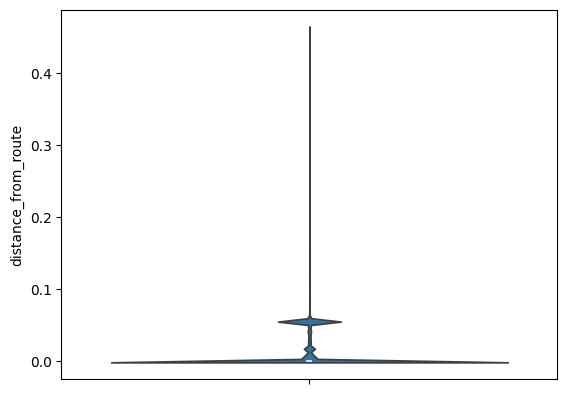

In [30]:
sns.violinplot(bus_positions['distance_from_route'])